# Web Mining and Applied NLP (44-620)

## Web Scraping and NLP with Requests, BeautifulSoup, and spaCy

### Student Name: Joanna Farris

##### GitHub Repo: [https://github.com/Pojetta/module_06](https://github.com/Pojetta/module_06)

Perform the tasks described in the Markdown cells below.  When you have completed the assignment make sure your code cells have all been run (and have output beneath them) and ensure you have committed and pushed ALL of your changes to your assignment repository.

Every question that requires you to write code will have a code cell underneath it; you may either write your entire solution in that cell or write it in a python file (`.py`), then import and run the appropriate code to answer the question.

### Setup and register custom sentiment extensions

In [ ]:
import json  
import pathlib  
import pickle  
from collections import Counter  
  
import requests  
from bs4 import BeautifulSoup  
import matplotlib.pyplot as plt  
import spacy  
from spacy.tokens import Doc  
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load("en_core_web_sm")  
nlp.add_pipe("spacytextblob")

In [49]:
if not Doc.has_extension("polarity"):  
    Doc.set_extension("polarity", getter=lambda doc: doc._.blob.sentiment.polarity)  
  
if not Doc.has_extension("subjectivity"):  
    Doc.set_extension("subjectivity", getter=lambda doc: doc._.blob.sentiment.subjectivity)  
  
if not Doc.has_extension("assessments"):  
    Doc.set_extension("assessments", getter=lambda doc: doc._.blob.sentiment_assessments.assessments)

## Question 1

Write code that extracts the article html from https://web.archive.org/web/20210327165005/https://hackaday.com/2021/03/22/how-laser-headlights-work/ and dumps it to a .pkl (or other appropriate file)

In [50]:
article_page = requests.get('https://web.archive.org/web/20210327165005/https://hackaday.com/2021/03/22/how-laser-headlights-work/')
article_html = article_page.text

with open('laser_headlights.pkl', 'wb') as f:
    pickle.dump(article_html, f)

## Question 2 

Read in your article's html source from the file you created in question 1 and print it's text (use `.get_text()`)

In [62]:
with open('laser_headlights.pkl', 'rb') as f:
    article_html = pickle.load(f)

soup = BeautifulSoup(article_html, "html.parser")
article_element = soup.find("article")
article_text = article_element.get_text() if article_element else soup.get_text()

print(article_text)

# Cut everything after "Leave a comment" if that exists
cutoff_phrase = "Leave a comment"
if cutoff_phrase in article_text:
    article_text = article_text.split(cutoff_phrase)[0]

article_text = article_text.strip()



How Laser Headlights Work


                130 Comments            

by:
Lewin Day



March 22, 2021








When we think about the onward march of automotive technology, headlights aren’t usually the first thing that come to mind. Engines, fuel efficiency, and the switch to electric power are all more front of mind. However, that doesn’t mean there aren’t thousands of engineers around the world working to improve the state of the art in automotive lighting day in, day out.
Sealed beam headlights gave way to more modern designs once regulations loosened up, while bulbs moved from simple halogens to xenon HIDs and, more recently, LEDs. Now, a new technology is on the scene, with lasers!

Laser Headlights?!
BWM’s prototype laser headlight assemblies undergoing testing.
The first image brought to mind by the phrase “laser headlights” is that of laser beams firing out the front of an automobile. Obviously, coherent beams of monochromatic light would make for poor illumination outside o

## Question 3 

Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent tokens (converted to lower case).  Print the common tokens with an appropriate label.  Additionally, print the tokens their frequencies (with appropriate labels). Make sure to remove things we don't care about (punctuation, stopwords, whitespace).

In [52]:
doc = nlp(article_text)

def we_care_about(token):
    return (
        not token.is_space
        and not token.is_punct
        and not token.is_stop
        and token.is_alpha  # only alphabetic words
        and len(token.text) > 2  # ignore short junk like "at", "to"
    )

tokens = [token.text.lower() for token in doc if we_care_about(token)]

token_freq = Counter(tokens)

top_5 = token_freq.most_common(5)

print("Top 5 Most Common Tokens (excluding stopwords, punctuation, and whitespace):")
print([token for token, count in top_5])

print("\nTop 5 Most Common Tokens (excluding stopwords, punctuation, and whitespace):")
for word, count in top_5:
    print(f"{word}: {count}")

Top 5 Most Common Tokens (excluding stopwords, punctuation, and whitespace):
['laser', 'headlights', 'headlight', 'technology', 'led']

Top 5 Most Common Tokens (excluding stopwords, punctuation, and whitespace):
laser: 35
headlights: 19
headlight: 11
technology: 10
led: 10


## Question 4 

Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent lemmas (converted to lower case).  Print the common lemmas with an appropriate label.  Additionally, print the lemmas with their frequencies (with appropriate labels). Make sure to remove things we don't care about (punctuation, stopwords, whitespace).

In [53]:
lemmas = [token.lemma_.lower() for token in doc if we_care_about(token)]

lemma_freq = Counter(lemmas)

top_5_lemmas = lemma_freq.most_common(5)

print("Top 5 Most Common Lemmas (excluding stopwords, punctuation, and whitespace):")
print([lemma for lemma, count in top_5_lemmas])

print("\nLemma Frequencies:")
for lemma, count in top_5_lemmas:
    print(f"{lemma}: {count}")

Top 5 Most Common Lemmas (excluding stopwords, punctuation, and whitespace):
['laser', 'headlight', 'beam', 'technology', 'led']

Lemma Frequencies:
laser: 40
headlight: 28
beam: 12
technology: 10
led: 10


## Question 5 

Define the following methods:  
  
    * `score_sentence_by_token(sentence, interesting_token)` that takes a sentence and a list of interesting token and returns the number of times that any of the interesting words appear in the sentence divided by the number of words in the sentence. 
  
    * `score_sentence_by_lemma(sentence, interesting_lemmas)` that takes a sentence and a list of interesting lemmas and returns the number of times that any of the interesting lemmas appear in the sentence divided by the number of words in the sentence
    
You may find some of the code from the in class notes useful; feel free to use methods (rewrite them in this cell as well).  Test them by showing the score of the first sentence in your article using the frequent tokens and frequent lemmas identified in question 3.

In [54]:
def score_sentence_by_token(sentence, interesting_tokens):
    tokens = [token.text.lower() for token in sentence if not token.is_space]
    matches = [token for token in tokens if token in interesting_tokens]
    return len(matches) / len(tokens) if tokens else 0

def score_sentence_by_lemma(sentence, interesting_lemmas):
    lemmas = [token.lemma_.lower() for token in sentence if not token.is_space]
    matches = [lemma for lemma in lemmas if lemma in interesting_lemmas]
    return len(matches) / len(lemmas) if lemmas else 0

sentences = list(doc.sents)

def sentence_score(index):
    try:
        sent = sentences[index]
        print(f"Sentence {index}:")
        print(f"  Score by token: {score_sentence_by_token(sent, [t for t, _ in top_5]):.3f}")
        print(f"  Score by lemma: {score_sentence_by_lemma(sent, [l for l, _ in top_5_lemmas]):.3f}")
    except IndexError:
        print(f"No sentence found at index {index}.")

sentence_score(0)
sentence_score(1)
sentence_score(10)

Sentence 0:
  Score by token: 0.108
  Score by lemma: 0.081
Sentence 1:
  Score by token: 0.000
  Score by lemma: 0.000
Sentence 10:
  Score by token: 0.222
  Score by lemma: 0.222


## Question 6 

Make a list containing the scores (using tokens) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores. From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

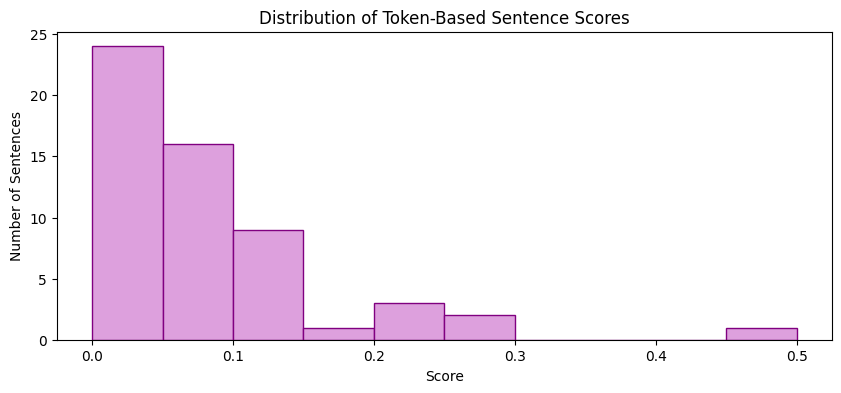

In [60]:
token_scores = [
    score_sentence_by_token(sent, [t for t, _ in top_5])
    for sent in sentences
]

# Histogram
plt.figure(figsize=(10, 4))  # width=10 inches, height=4 inches
plt.hist(token_scores, bins=10, color='plum', edgecolor='purple')
plt.title("Distribution of Token-Based Sentence Scores")
plt.xlabel("Score")
plt.ylabel("Number of Sentences")
plt.show()

# Most common token score range: 0.0 – 0.05

## Question 7 

Make a list containing the scores (using lemmas) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores.  From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

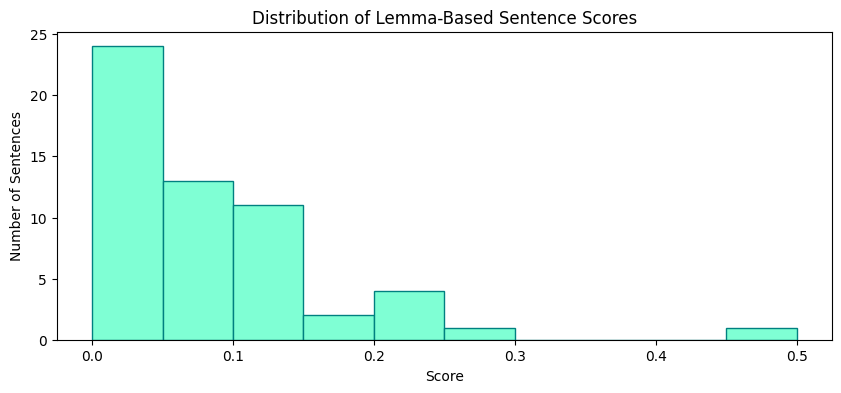

In [59]:
lemma_scores = [
    score_sentence_by_lemma(sent, [t for t, _ in top_5])
    for sent in sentences
]

# Histogram
plt.figure(figsize=(10, 4))  # width=10 inches, height=4 inches
plt.hist(lemma_scores, bins=10, color='aquamarine', edgecolor='teal')
plt.title("Distribution of Lemma-Based Sentence Scores")
plt.xlabel("Score")
plt.ylabel("Number of Sentences")
plt.show()

# Most common lemma score range: 0.0 – 0.05

## Question 8

Which tokens and lemmas would be omitted from the lists generated in questions 3 and 4 if we only wanted to consider nouns as interesting words?  How might we change the code to only consider nouns? Put your answer in this Markdown cell (you can edit it by double clicking it).

**Answer**: My code already returned only nouns. That wasn't my intention, but I had ChatGPT help me alter it to remove unimportant words that seemed like they were coming from the comments section, and this is what I was left with:

Top 5 Most Common Tokens: ['laser', 'headlights', 'headlight', 'technology', 'led']

Top 5 Most Common Lemmas: ['laser', 'headlight', 'beam', 'technology', 'led']

I'm not sure if there is a way to filter specifically for parts of speech, but I have a feeling there is!

#### Bonus:

        Me:  
        Is there a way to filter for parts of speech?  

        ChatGPT said:  
        Yes — absolutely! spaCy makes it super easy to filter tokens by part of speech (POS) using token.pos_.

        ✅ Example: Filter only nouns and verbs
        [token for token in doc if token.pos_ in ("NOUN", "VERB")]